---
# Examples of 2-D classifications using QDA and nearest-neighbors methods.
---

In this script, we show the differences in classification performances between the 
quadratic discriminant analysis (QDA) and the nearest-neighbors (kNN) methods. The former is parametric whereas 
the latter is nonparametric. 

On the one hand, parametric methods can be very powerful when they are applied to types of problems they 
were specifically designed to tackle. On the other hand, nonparametric methods, which are often intuitive 
and somewhat heuristic, are often used to handle more general situations.

In this script, both methods are applied to a series of 2-D datasets, containing 2 classes, with an 
increasing level of spatial complexity. 

## QDA method
This method approximates the PDF of each class as a multi-normal gaussian distribution which parameters are 
adjusted to fit the observations. Hence, the parameters are estimated from the datasets and the 
QDA uses that information to model the boundary where the two class probabilities overlap. This 
defines the influence zone of each class.

## kNN method
This other method is probably the most intuitive approach of all. Having a dataset made of observations X 
belonging to several classes, it assigns, to a location x, the winning class from a pool made of the k 
nearest observations X from that location.
                                   
Several distance metrics can be used to compute the distance between $X$ and $x$ but the euclidean distance, 
used in this script, is the most popular one. 


In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
sns.set()

# Used for reproductibility of the results
np.random.seed(42)

Automatically created module for IPython interactive environment


# A few useful functions

Let us first define several functions that will be used to generate each classification example.

## Data normalization
Normalize dataset for easier parameter selection for the classification methods.

In [2]:
def normalize_dataset(X, nbins):
    X = StandardScaler().fit_transform(X)
    x_min = 1.1 * X[:,0].min()
    x_max = 1.1 * X[:,0].max()
    y_min = 1.1 * X[:,1].min()
    y_max = 1.1 * X[:,1].max()

    # Generate a spatial grid where the PDF will be evaluated locally.
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nbins), np.linspace(y_min, y_max, nbins))
    Xgrid = np.c_[xx.ravel(), yy.ravel()]
    
    return (X, Xgrid, xx, yy, x_min, x_max, y_min, y_max)

## Classification results displaying function 

In [3]:
def display_classification_results(nNeighbors, C_KNN, C_qda, X, y, Xgrid, figName, drawQDAboundary=True):

    cm_dim = ListedColormap(['#00BB00', '#0000BB'])
    cm_bright = ListedColormap(['#00FF00', '#0000FF'])
    
    fig, axs = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True) 
    for k in range(6):
        ax = axs.ravel()[k]

        if (k==0):
            # QDA classification results
            ax.pcolormesh(xx, yy, C_qda, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='w')
            if (drawQDAboundary==True):
                ax.contour(xx, yy, C_qda, [0.5], linewidths=2., colors='yellow') 
            ax.set_title('QDA', fontsize=18, color='k')
        else:
            # k-Nearest-Neighbors classification results    
            ax.pcolormesh(xx, yy, C_KNN[:,:,k-1], cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='w')
            if (drawQDAboundary==True):
                ax.contour(xx, yy, C_qda, [0.5], linewidths=2., colors='yellow') 
            ax.set_title('KNN k=%d' % (nNeighbors[k-1]), fontsize=18, color='k')

        ax.set_xlim([x_min,x_max])
        ax.set_ylim([y_min,y_max])
        ax.set_xlabel('$x_{1}$', fontsize=14)
        ax.set_ylabel('$x_{2}$', fontsize=14, rotation=0) 
        ax.xaxis.set_label_coords(0.5, -0.05) 
        ax.yaxis.set_label_coords(-0.05, 0.5) 
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.grid(None)  
        ax.grid(None) 
    
    fig.tight_layout()
        
    plt.savefig(figName + '.png')
    plt.savefig(figName + '.pdf')

# Comparison of classification results obtained with QDA and Nearest-Neighbors methods 
## Initialisations

In [4]:
# Number of 2-D points per dataset.
npts = 200

# A priori probability of the clusters
prob_C = np.array([0.5, 0.5]) 

# Number of data points allocated to each cluster 
nc = (npts*prob_C).astype(int)

# Number of spatial bins used in each spatial direction
nbins = 500

# Quadratic discriminant analysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)

## Noisy concentric circles (easy case)

This example shows two concentric and well separated data distributions. As expected, the nearest-neighbors results
vary considerably with the number of neighbors. The most circular boundary is observed with k=10. Notice how the 
boundary radius and roughness increase with the value of k. The QDA boundary is overlaid on the kNN results as a reference.


In [5]:
X,y = datasets.make_circles(n_samples=npts, factor=.5, noise=.05)

# Normalize dataset
(X, Xgrid, xx, yy, x_min, x_max, y_min, y_max) = normalize_dataset(X, nbins)


In [6]:
C_qda = qda.fit(X, y).predict(Xgrid) 
C_qda = C_qda.reshape(xx.shape)

nNeighbors = np.array([1, 10, 20, 30, 40])
C_KNN = np.zeros((nbins, nbins, 5), dtype=int)
for i,n in enumerate(nNeighbors):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X, y)
    c = clf.predict(Xgrid)
    C_KNN[:,:,i] = c.reshape(xx.shape)


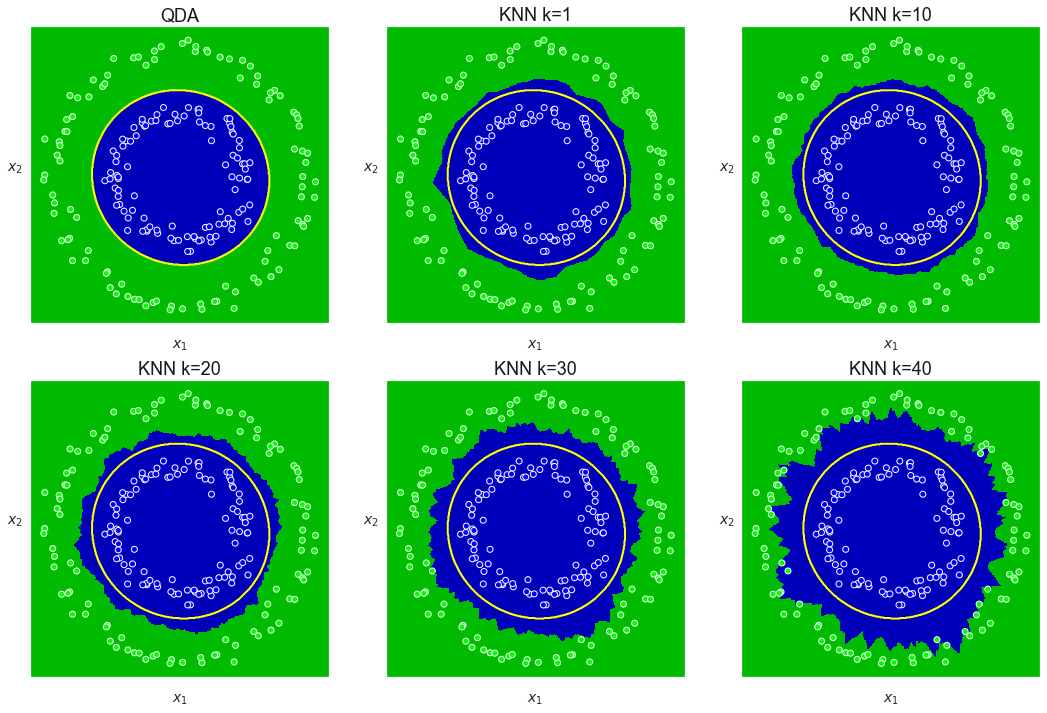

In [7]:
# Compare classification results
figName = '2D_KNN_classif_circles_1'
display_classification_results(nNeighbors, C_KNN, C_qda, X, y, Xgrid, figName)

## Noisy concentric circles (harder case)

This example shows two overlapping concentric and noisy data distributions. The QDA boundary is once again quite good as 
it separates most blue and green points correctly. 

This is a much harder task for the kNN approach. As before, the best boundary is observed 
with k=10. This is a compromise between the number of neighbors used and their sparsity. The solution for k=10 is also a minimum in boundary 
roughness and mean radius.


In [8]:
X,y = datasets.make_circles(n_samples=npts, factor=.75, noise=.1)

# Normalize dataset
(X, Xgrid, xx, yy, x_min, x_max, y_min, y_max) = normalize_dataset(X, nbins)

In [9]:
C_qda = qda.fit(X, y).predict(Xgrid) 
C_qda = C_qda.reshape(xx.shape)

nNeighbors = np.array([1, 10, 20, 30, 40])
C_KNN = np.zeros((nbins, nbins, 5), dtype=int)
for i,n in enumerate(nNeighbors):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X, y)
    c = clf.predict(Xgrid)
    C_KNN[:,:,i] = c.reshape(xx.shape)

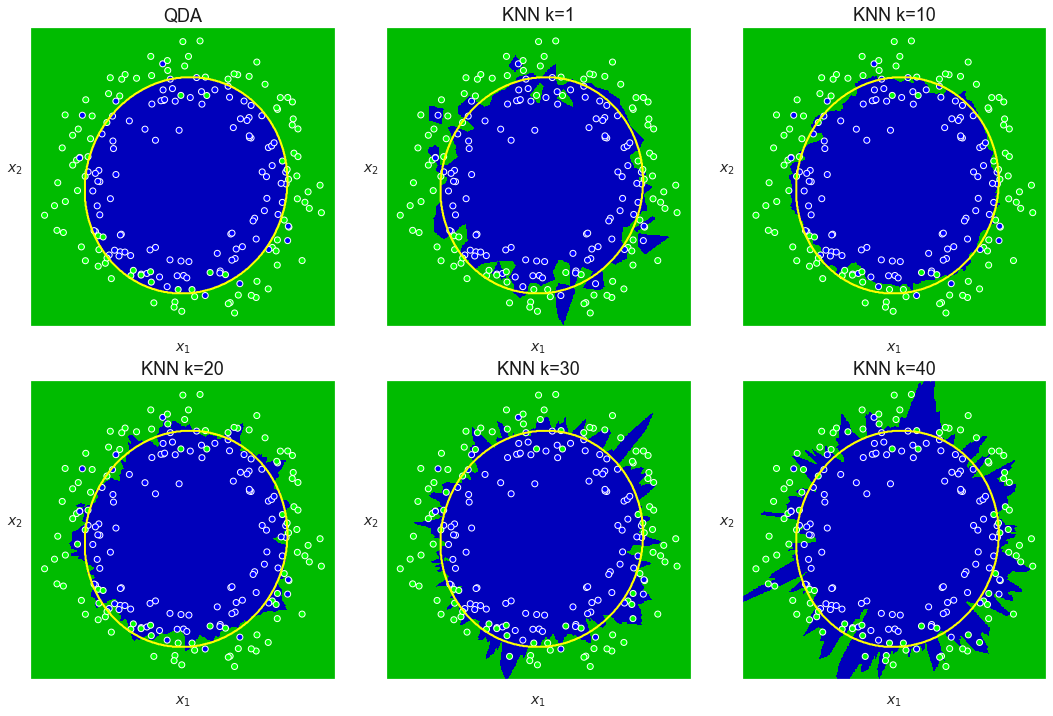

In [10]:
# Compare classification results
figName = '2D_KNN_classif_circles_2'
display_classification_results(nNeighbors, C_KNN, C_qda, X, y, Xgrid, figName)

## Increasing the number of data points

The previous example was quite a challenge for the kNN method. Algorithms usually fare better when more data is available. 
This is clearly the case in the figure below where all kNN classification results for $k>1$ are similar and approximate 
the QDA boundary.

In [11]:
npts = 500
X,y = datasets.make_circles(n_samples=npts, factor=.75, noise=.1)

# Normalize dataset
(X, Xgrid, xx, yy, x_min, x_max, y_min, y_max) = normalize_dataset(X, nbins)

In [12]:
C_qda = qda.fit(X, y).predict(Xgrid) 
C_qda = C_qda.reshape(xx.shape)

nNeighbors = np.array([1, 10, 20, 30, 40])
C_KNN = np.zeros((nbins, nbins, 5), dtype=int)
for i,n in enumerate(nNeighbors):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X, y)
    c = clf.predict(Xgrid)
    C_KNN[:,:,i] = c.reshape(xx.shape)

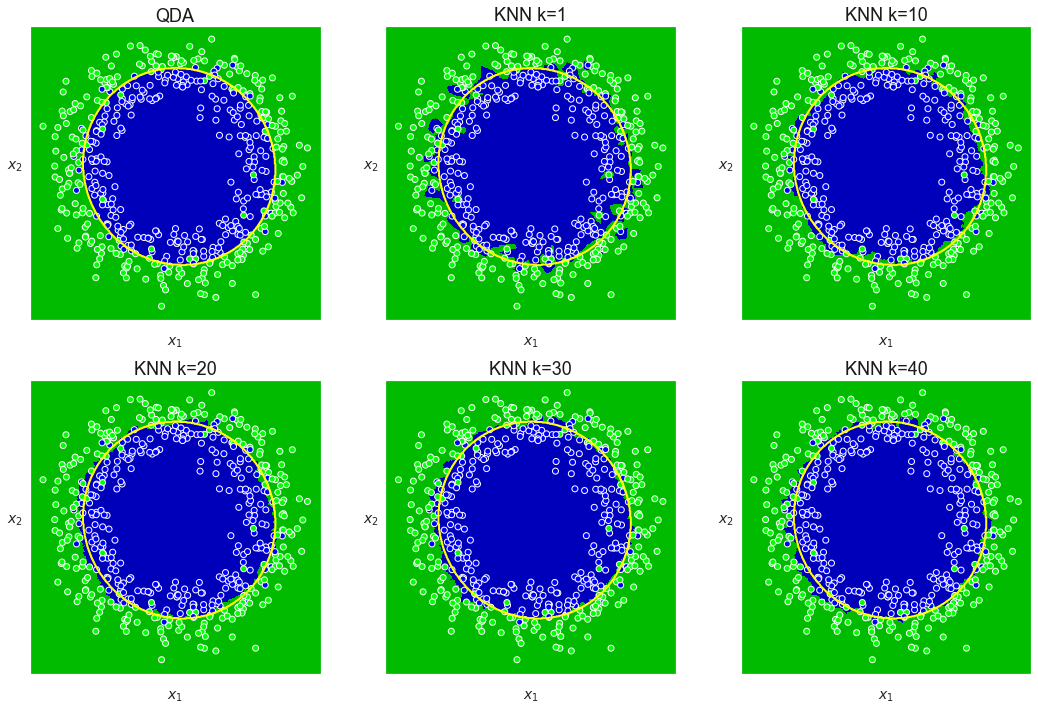

In [13]:
# Compare classification results
figName = '2D_KNN_classif_circles_3'
display_classification_results(nNeighbors, C_KNN, C_qda, X, y, Xgrid, figName)

# Noisy crescents (a much harder case)

This example shows more complex boundaries. In this situation, the QDA method cannot well delineate the influence zones since 
the boundaries can be neither linear nor quadratic. The kNN method fares better here.

The best the QDA method could do was to produce a linear boundary which separates most 
green dots on the upper left from the blue dots on the lower right. Optimal kNN results are found with k=20; most of 
the data points are correctly classified. Increasing the number of neighbors smooths out the boundary 
which eventually produces a roughly linear one in the spirit of the QDA solution. 


In [14]:
npts = 200
X,y = datasets.make_moons(n_samples=npts, noise=.15)

# Normalize dataset
(X, Xgrid, xx, yy, x_min, x_max, y_min, y_max) = normalize_dataset(X, nbins)


In [15]:
C_qda = qda.fit(X, y).predict(Xgrid) 
C_qda = C_qda.reshape(xx.shape)

nNeighbors = np.array([1, 10, 20, 30, 150])
C_KNN = np.zeros((nbins, nbins, 5), dtype=int)
for i,n in enumerate(nNeighbors):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X, y)
    c = clf.predict(Xgrid)
    C_KNN[:,:,i] = c.reshape(xx.shape)

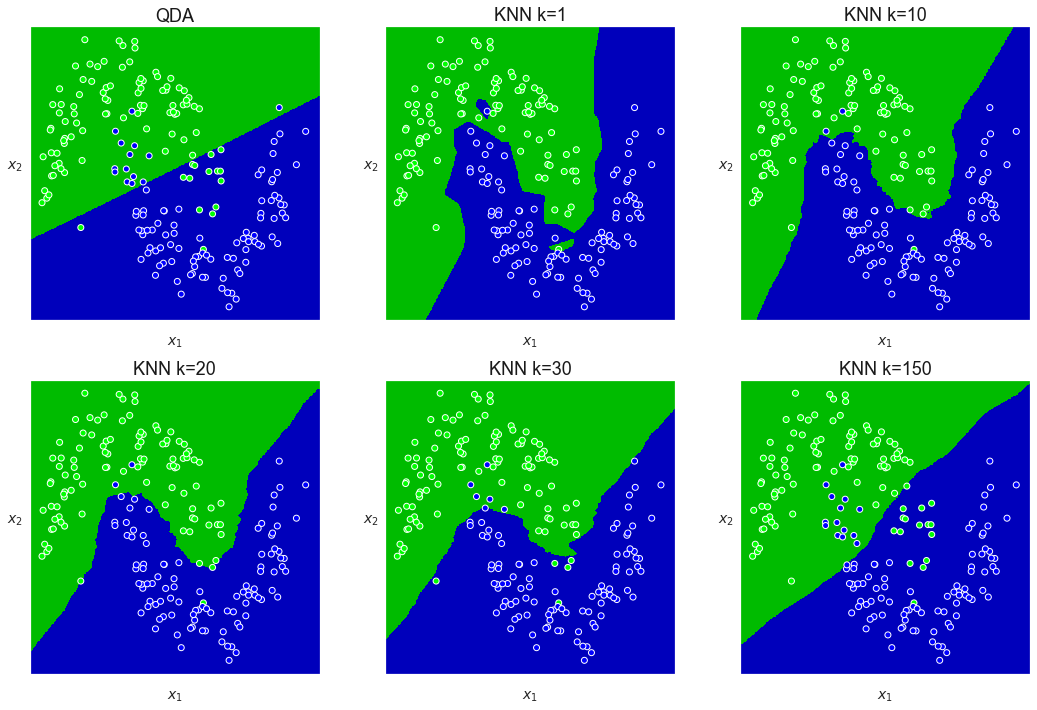

In [16]:
# Compare classification results
figName = '2D_KNN_classif_crescents'
display_classification_results(nNeighbors, C_KNN, C_qda, X, y, Xgrid, figName, drawQDAboundary=False)